In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./_A_embeddings/A00_setup.py").load_module()

## Neural Network With NAICS Hierarchy Codes, Intermediate Embedding Layer
Use the custom data generator to inject unseen codes into the data during training (with shuffle).  Add a layer in the network to combine all NAICS-hierarchy inputs

Similar to "12" in the parent folder, but add an additional layer in the neural network

Use the dataset with no missing values. 

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

import tensorflow.keras as keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model
from sba_nn.sba_nn.sbnn_model import CatInjectGenerator

## Input Data

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [7]:
with open(Path(setup.parent_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [8]:
with open(Path(setup.parent_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)

##### Features

In [9]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [10]:
# NAICS feature - just bas
features_naics = ['NAICS', 'NAICS_4', 'NAICS_3', 'NAICS_sector']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [11]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170, 345, 107, 21]
[8, 4, 4, 2]


##### Datasets for train, validation

In [12]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric + features_naics].set_index('LoanNr_ChkDgt').sort_index()

In [13]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 14), y:(446848,)


In [14]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 14), y:(95604,)


In [15]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


## Create, fit model

In [16]:
importlib.reload(sbnn_model)

<module 'sba_nn.sba_nn.sbnn_model' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_model.py'>

In [17]:
this_model = \
    sbnn_model.create_emb_model_intermediate(features_numeric_len,
                                            features_naics_max_levels,
                                            features_naics_emb_dim,
                                            naics_embedding_names = features_naics,
                                            hidden_size = setup.nn_layer_sizes,
                                            activation='tanh',
                                            lr=setup.nn_learning_rate,
                                            opt_func = setup.nn_optimizer,
                                            dropout = setup.nn_dropout)

2024-07-12 07:13:41.893477: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-12 07:13:41.893524: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-12 07:13:41.893540: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-12 07:13:41.893611: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-12 07:13:41.893635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_01 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 input_naics_02 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                            

##### Use data generator to inject 1 values into training data

In [19]:
generator = CatInjectGenerator(X_train, y_train,
                               categorical_columns=features_naics,
                               batch_size = setup.nn_batch_size,
                               injection_rate = 0.1,
                               injection_value = 1)

In [20]:
callback = keras.callbacks.EarlyStopping(patience=3)

In [21]:
this_history = this_model.fit(generator,
                              batch_size=setup.nn_batch_size,
                              epochs = setup.nn_epochs,
                              validation_data=([X_val[features_numeric]] + [X_val[f] for f in features_naics], 
                                               y_val),
                              shuffle=True,
                              callbacks=[callback])

Epoch 1/20


2024-07-12 07:13:42.900537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13963/13964 [============================>.] - ETA: 0s - loss: 0.4637 - auc: 0.3331 - auc_1: 0.6970

2024-07-12 07:17:29.065504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13964/13964 [==============================] - 251s 18ms/step - loss: 0.4637 - auc: 0.3332 - auc_1: 0.6970 - val_loss: 0.4546 - val_auc: 0.3680 - val_auc_1: 0.7213
Epoch 2/20
13964/13964 [==============================] - 237s 17ms/step - loss: 0.4558 - auc: 0.3550 - auc_1: 0.7138 - val_loss: 0.4522 - val_auc: 0.3748 - val_auc_1: 0.7263
Epoch 3/20
13964/13964 [==============================] - 240s 17ms/step - loss: 0.4539 - auc: 0.3603 - auc_1: 0.7180 - val_loss: 0.4509 - val_auc: 0.3797 - val_auc_1: 0.7280
Epoch 4/20
13964/13964 [==============================] - 241s 17ms/step - loss: 0.4530 - auc: 0.3636 - auc_1: 0.7197 - val_loss: 0.4507 - val_auc: 0.3809 - val_auc_1: 0.7290
Epoch 5/20
13964/13964 [==============================] - 241s 17ms/step - loss: 0.4526 - auc: 0.3653 - auc_1: 0.7206 - val_loss: 0.4501 - val_auc: 0.3826 - val_auc_1: 0.7303
Epoch 6/20
13964/13964 [==============================] - 242s 17ms/step - loss: 0.4519 - auc: 0.3687 - auc_1: 0.7222 - val_loss: 0.4505

In [22]:
this_history_df = sbnn_model.process_history(this_history)

In [23]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('A01_REPORT_fit_history.csv'))

<Axes: >

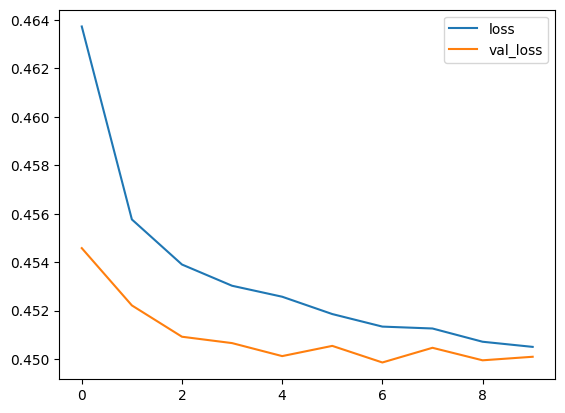

In [24]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

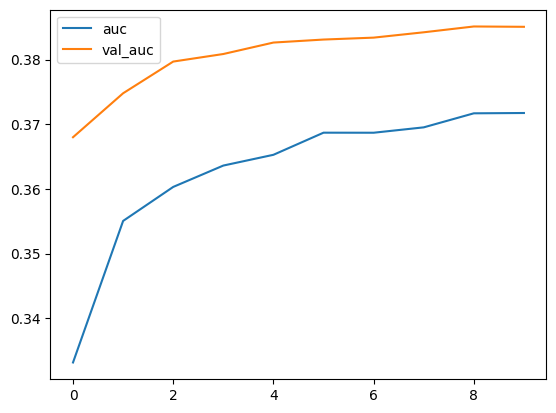

In [25]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

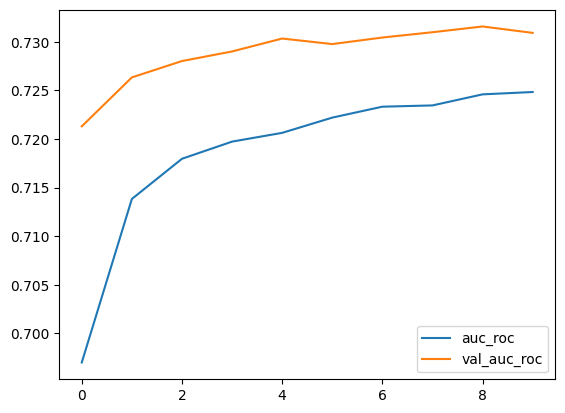

In [26]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [27]:
this_model.save(Path(setup.temp_path).joinpath('A01_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [28]:
all_predictions = this_model.predict([X[features_numeric]]+ [X[f] for f in features_naics])

   88/21735 [..............................] - ETA: 38s

2024-07-12 07:53:19.932268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21735/21735 [==============================] - 47s 2ms/step


In [29]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [30]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.323077
target,0.323077,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [31]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [32]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [33]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
11,0.22,0.452129
10,0.20,0.451237
9,0.18,0.448291


In [34]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.22

##### Append binary predictions to probability predictions

In [35]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [36]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.598922
1    0.401078
Name: proportion, dtype: float64

In [37]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('A01_DATA_predictions.parquet'))

## Metrics

In [38]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('A01_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.673671,0.448997,0.340455,0.659141,0.380537,0.730883,NaN
1,train,0.667762,0.452129,0.339237,0.677633,0.385906,0.732818,NaN
2,val,0.667681,0.453082,0.340897,0.675322,0.385185,0.730949,NaN
0,test,0.664462,0.446837,0.335945,0.667010,0.379213,0.726232,0.0
1,test,0.688977,0.452829,0.348648,0.645806,0.386496,0.738980,1.0


The performance is very similar to 12. 